In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import torch

C:\Users\hy138\AppData\Local\Temp\ipykernel_12976\3508959855.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def extract_topic_name(flight_name, file_name):
    topic_name = file_name.split(flight_name)
    topic_name =  topic_name[1].strip("-") if len(topic_name)>1 else ""
    topic_name = topic_name.split(".csv")[0]
    return topic_name

In [3]:
def read_data(full_path):
    df_tmp = pd.read_csv(full_path,on_bad_lines="skip")
    df_tmp = df_tmp.rename(columns={"%time": "timestamp"})
    
    df_tmp["timestamp"] = pd.to_datetime(df_tmp["timestamp"], unit="ns")
    df_tmp.set_index("timestamp", inplace=True) 
    return df_tmp


In [4]:
data_path = "./data/processed/"

In [5]:
unused_topic_list = ["diagnostics", "emergency_responder-traj_file","mavlink-from","mavros-state",
                    "global_position",
                     "local_position", 
                     "mavctrl-rpy",
                     "mavros-battery", "field_raw",
                     "mavros-imu-mag", "mavros-mission-reached",
                     "mavros-rc",
                      "setpoint_raw","mavros-imu-data_raw"]

unused_column_list = ["field.header.seq", "field.header.stamp", "field.header.frame_id", 
                      "field.commanded", "field.variance", "%time","field.x","field.twist.angular.x","field.twist.angular.y","field.twist.angular.z",
                      'field.orientation_covariance0',
       'field.orientation_covariance1',
       'field.orientation_covariance2',
       'field.orientation_covariance3',
       'field.orientation_covariance4',
       'field.orientation_covariance5',
       'field.orientation_covariance6',
       'field.orientation_covariance7',
       'field.orientation_covariance8',

       'field.angular_velocity_covariance0',
       'field.angular_velocity_covariance1',
       'field.angular_velocity_covariance2',
       'field.angular_velocity_covariance3',
       'field.angular_velocity_covariance4',
       'field.angular_velocity_covariance5',
       'field.angular_velocity_covariance6',
       'field.angular_velocity_covariance7',
       'field.angular_velocity_covariance8',

       'field.linear_acceleration_covariance0',
       'field.linear_acceleration_covariance1',
       'field.linear_acceleration_covariance2',
       'field.linear_acceleration_covariance3',
       'field.linear_acceleration_covariance4',
       'field.linear_acceleration_covariance5',
       'field.linear_acceleration_covariance6',
       'field.linear_acceleration_covariance7',
       'field.linear_acceleration_covariance8',
       "field.coordinate_frame","field.source"]

In [6]:
print(os.getcwd())
print(os.listdir())

c:\Users\hy138\Desktop\UAV
['.vscode', 'best_model.pth', 'BiLSTM.ipynb', 'BiLSTMs.ipynb', 'CNN1D.ipynb', 'CNN1Ds.ipynb', 'data', 'LSTM.ipynb', 'LSTMAutoEncoder.ipynb', 'LSTMs.ipynb', 'Yeni klasör']


In [7]:
time_dict = {}
flight_topic_list = []
topic_list = []
all_columns = []
df_dict = {}
failure_status_dict = {}

In [8]:
print(topic_list)

[]


In [9]:
for i,flight in enumerate(glob.glob(data_path+"*")):
    
    flight_name = os.path.basename(flight)
    
    if "no_ground_truth" in flight_name:
        continue
    if "no_failure" in flight_name:
            continue
    # This folder has not path-dev csv file
    if "carbonZ_2018-09-11-15-06-34_3_rudder_left_failure" in flight_name:
        continue
    print(flight_name)

    if flight_name not in flight_topic_list:
        flight_topic_list.append(flight_name)
    

    df_failure = None
    failure_duration_start = pd.Timestamp('1970-01-01')
    failure_duration_finish = pd.Timestamp('1970-01-01')

    dfs = list()
    for i , file in enumerate(glob.glob(os.path.join(data_path,flight_name,"*.csv"))):
        
        if any(x in file for x in unused_topic_list):
            continue
        

        if "failure_status" in os.path.basename(file):
            file_name = os.path.basename(file)
            
            df = read_data(file)
            topic_name = extract_topic_name(flight_name,file_name)

            
            failure_duration_start = min(df.index)
            failure_duration_end = max(df.index)

            failure_status_dict[flight_name] = (failure_duration_start,failure_duration_end)

            continue
        
        file_name = os.path.basename(file)

        df = read_data(file)
        topic_name = extract_topic_name(flight_name,file_name)
        for col in unused_column_list:
            if col in df.columns:
                df.drop(col,axis=1,inplace=True)
        new_columns = list(map(lambda x: f"{topic_name}.{x.replace('field.', '')}", df.columns))
        df = df.set_axis(new_columns, axis=1)
       
     
        
        dfs.append(df)

   
    df_dict[flight_name] = dfs

    

carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [10]:
len(df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"])

13

In [11]:
len(df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0]),df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0].isna().sum()

(6619,
 mavctrl-path_dev.y    0
 mavctrl-path_dev.z    0
 dtype: int64)

In [12]:
failure_status_dict

{'carbonZ_2018-07-18-15-53-31_1_engine_failure': (Timestamp('2018-07-18 19:58:47.129305993'),
  Timestamp('2018-07-18 19:59:03.134074845')),
 'carbonZ_2018-07-18-15-53-31_2_engine_failure': (Timestamp('2018-07-18 20:01:44.729304590'),
  Timestamp('2018-07-18 20:01:59.928010526')),
 'carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj': (Timestamp('2018-07-18 20:32:26.878396465'),
  Timestamp('2018-07-18 20:32:42.672828037')),
 'carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj': (Timestamp('2018-07-18 20:46:37.888445250'),
  Timestamp('2018-07-18 20:46:54.288954056')),
 'carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj': (Timestamp('2018-07-21 00:35:22.170194'),
  Timestamp('2018-07-21 00:35:41.166058768')),
 'carbonZ_2018-07-30-16-39-00_1_engine_failure': (Timestamp('2018-07-21 01:00:21.380769776'),
  Timestamp('2018-07-21 01:00:36.175981200')),
 'carbonZ_2018-07-30-16-39-00_2_engine_failure': (Timestamp('2018-07-21 01:04:00.575490608'),
  Timestamp('2018-07-21 0

In [13]:
# for key,data in df_dict.items():
#     df_list = []
#     for df in data:
#         for col in df.columns:
#             df[f'{col}_copy'] = df[col] 
    
#         df_list.append(df)
#     df_dict[key] = df_list

In [14]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
13
carbonZ_2018-07-18-15-53-31_2_engine_failure
13
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-39-00_1_engine_failure
13
carbonZ_2018-07-30-16-39-00_2_engine_failure
13
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
13
carbonZ_2018-09-11-11-56-30_engine_failure
13
carbonZ_2018-09-11-14-22-07_1_engine_failure
13
carbonZ_2018-09-11-14-22-07_2_engine_failure
13
carbonZ_2018-09-11-14-41-51_elevator_failure
13
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
13
carbonZ_2018-09-11-15-05-11_1_elevator_failure
13
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
13
carbonZ_2018-09-11-15-06

In [15]:
for key, data in df_dict.items():
    if "rudder_zero__left_aileron_failure" in key:
        

        df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"] = df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure'].copy()
 
 

        df_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"] = df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure'].copy()

   

        del df_dict['carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure']


        break
 


In [16]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
13
carbonZ_2018-07-18-15-53-31_2_engine_failure
13
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-16-39-00_1_engine_failure
13
carbonZ_2018-07-30-16-39-00_2_engine_failure
13
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
13
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
13
carbonZ_2018-09-11-11-56-30_engine_failure
13
carbonZ_2018-09-11-14-22-07_1_engine_failure
13
carbonZ_2018-09-11-14-22-07_2_engine_failure
13
carbonZ_2018-09-11-14-41-51_elevator_failure
13
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
13
carbonZ_2018-09-11-15-05-11_1_elevator_failure
13
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
13
carbonZ_2018-09-11-15-06

In [17]:
for key, data in failure_status_dict.items():
    if "rudder_zero__left_aileron_failure" in key:
        failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"] = failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        failure_status_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"] = failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        del failure_status_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure"]
        break

In [18]:
df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"][1].columns

Index(['mavros-imu-atm_pressure.fluid_pressure'], dtype='object')

In [19]:
df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"][0]

,mavctrl-path_dev.y,mavctrl-path_dev.z
timestamp,,
2018-07-18 19:56:50.820860792,141.284886,14.438259
2018-07-18 19:56:50.840917944,141.284886,14.438259
2018-07-18 19:56:50.861388914,141.284886,14.438259
2018-07-18 19:56:50.880812090,141.284886,14.438259
2018-07-18 19:56:50.901712334,144.798264,14.394005
...,...,...
2018-07-18 19:59:03.108804965,8.337481,21.670137
2018-07-18 19:59:03.130722624,8.337481,21.670137
2018-07-18 19:59:03.149511356,8.337481,21.670137


In [20]:
flight_topic_list.append("carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure")
flight_topic_list.append("carbonZ_2018-09-11-17-27-13_1_left_aileron_failure")
flight_topic_list.remove("carbonZ_2018-09-11-17-27-13_1_rudder_zero__left_aileron_failure")


In [21]:
len(flight_topic_list)

36

In [22]:
failure_status_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"]

(Timestamp('2018-07-18 19:58:47.129305993'),
 Timestamp('2018-07-18 19:59:03.134074845'))

In [23]:
df = df_dict["carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure"]
df

[                               mavctrl-path_dev.y  mavctrl-path_dev.z
 timestamp                                                            
 2018-09-11 18:55:44.748852696          226.349940          -16.530594
 2018-09-11 18:55:44.768693912          226.349940          -16.530594
 2018-09-11 18:55:44.793884088          207.499653          -16.530594
 2018-09-11 18:55:44.809683352          207.499366          -16.530594
 2018-09-11 18:55:44.831660792          207.499366          -16.530594
 ...                                           ...                 ...
 2018-09-11 18:59:38.029159576            5.033987            3.622774
 2018-09-11 18:59:38.049874936            5.033987            3.622774
 2018-09-11 18:59:38.073666904            5.033987            3.622774
 2018-09-11 18:59:38.089277368            4.698973            4.732197
 2018-09-11 18:59:38.109449304            4.698973            4.732197
 
 [11669 rows x 2 columns],
                                mavros-imu-atm_p

Failure Status:
    
    Engine     = 1
    Rudder     = 2
    Aileron    = 3
    Elevator   = 4

In [24]:
def add_failure(flight_name,df_failure,failure_duration_start,failure_duration_end):
    if "engine" in flight_name:
        failure_status = [
        1 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "rudder" in flight_name:
        failure_status = [
        2 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "aileron" in flight_name:
        failure_status = [
        3 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
    elif "elevator" in flight_name:
        failure_status = [
        4 if (x > failure_duration_start and x < failure_duration_end) else 0 
        for x in df_failure.index
                ]
        
    df_failure["failure_status"] = failure_status
        
    return df_failure

In [25]:
flight_topic_list

['carbonZ_2018-07-18-15-53-31_1_engine_failure',
 'carbonZ_2018-07-18-15-53-31_2_engine_failure',
 'carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj',
 'carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-16-39-00_1_engine_failure',
 'carbonZ_2018-07-30-16-39-00_2_engine_failure',
 'carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj',
 'carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj',
 'carbonZ_2018-09-11-11-56-30_engine_failure',
 'carbonZ_2018-09-11-14-22-07_1_engine_failure',
 'carbonZ_2018-09-11-14-22-07_2_engine_failure',
 'carbonZ_2018-09-11-14-41-51_elevator_failure',
 'carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure',
 'carbonZ_2018-09-11-15-05-11_1_elevator_failure',
 'carbonZ_2018-09-11-15-06-34_1_rudder_right_failure',
 'carb

In [26]:
for flight_name in flight_topic_list:
    print(flight_name)
    dfs = df_dict[flight_name] 
    
    start_time = min(min(dfs[0].index),min(dfs[1].index),min(dfs[2].index),min(dfs[3].index),min(dfs[4].index),min(dfs[5].index),min(dfs[6].index),min(dfs[7].index),min(dfs[8].index),min(dfs[9].index),min(dfs[10].index),min(dfs[11].index),min(dfs[12].index))
    end_time = max(max(dfs[0].index),max(dfs[1].index),max(dfs[2].index),max(dfs[3].index),max(dfs[4].index),max(dfs[5].index),max(dfs[6].index),max(dfs[7].index),max(dfs[8].index),max(dfs[9].index),max(dfs[10].index),max(dfs[11].index),max(dfs[12].index))
    
    time_index = pd.date_range(start=start_time, end=end_time, freq="200ms")  
    data = [0] * len(time_index)

    df_failure = pd.DataFrame(data, index=time_index, columns=["failure_status"])

    failure_duration_start = failure_status_dict[flight_name][0]
    failure_duration_end   = failure_status_dict[flight_name][1]
    
    
    df_dict[flight_name].append(add_failure(flight_name,df_failure,failure_duration_start,failure_duration_end))

carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [27]:
df = df_dict["carbonZ_2018-09-11-17-27-13_1_left_aileron_failure"]
df[12].iloc[: , :]

,mavros-wind_estimation.twist.linear.x,mavros-wind_estimation.twist.linear.y,mavros-wind_estimation.twist.linear.z
timestamp,,,
2018-09-11 21:34:19.188548395,0.360470,1.439026,0.0
2018-09-11 21:34:19.566847897,0.352583,1.463511,0.0
2018-09-11 21:34:19.954091484,0.345375,1.496819,0.0
2018-09-11 21:34:20.421941571,0.328750,1.548180,0.0
2018-09-11 21:34:20.868431200,0.321009,1.588851,0.0
...,...,...,...
2018-09-11 21:36:40.589048991,-0.256345,2.252147,0.0
2018-09-11 21:36:40.936268682,-0.255210,2.252631,0.0
2018-09-11 21:36:41.422716742,-0.253657,2.253724,0.0


In [28]:
df = df_dict["carbonZ_2018-09-11-17-27-13_1_rudder_zero_failure"]
df[12]


,mavros-wind_estimation.twist.linear.x,mavros-wind_estimation.twist.linear.y,mavros-wind_estimation.twist.linear.z
timestamp,,,
2018-09-11 21:34:19.188548395,0.360470,1.439026,0.0
2018-09-11 21:34:19.566847897,0.352583,1.463511,0.0
2018-09-11 21:34:19.954091484,0.345375,1.496819,0.0
2018-09-11 21:34:20.421941571,0.328750,1.548180,0.0
2018-09-11 21:34:20.868431200,0.321009,1.588851,0.0
...,...,...,...
2018-09-11 21:36:40.589048991,-0.256345,2.252147,0.0
2018-09-11 21:36:40.936268682,-0.255210,2.252631,0.0
2018-09-11 21:36:41.422716742,-0.253657,2.253724,0.0


In [29]:
for key, df in df_dict.items():
    print(key)
    print(len(df))

carbonZ_2018-07-18-15-53-31_1_engine_failure
14
carbonZ_2018-07-18-15-53-31_2_engine_failure
14
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
14
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-16-39-00_1_engine_failure
14
carbonZ_2018-07-30-16-39-00_2_engine_failure
14
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
14
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
14
carbonZ_2018-09-11-11-56-30_engine_failure
14
carbonZ_2018-09-11-14-22-07_1_engine_failure
14
carbonZ_2018-09-11-14-22-07_2_engine_failure
14
carbonZ_2018-09-11-14-41-51_elevator_failure
14
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
14
carbonZ_2018-09-11-15-05-11_1_elevator_failure
14
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
14
carbonZ_2018-09-11-15-06

Birleştirme:

In [30]:
for i in df_dict["carbonZ_2018-07-18-15-53-31_1_engine_failure"]:
    print(i.columns)


Index(['mavctrl-path_dev.y', 'mavctrl-path_dev.z'], dtype='object')
Index(['mavros-imu-atm_pressure.fluid_pressure'], dtype='object')
Index(['mavros-imu-data.orientation.x', 'mavros-imu-data.orientation.y',
       'mavros-imu-data.orientation.z', 'mavros-imu-data.orientation.w',
       'mavros-imu-data.angular_velocity.x',
       'mavros-imu-data.angular_velocity.y',
       'mavros-imu-data.angular_velocity.z',
       'mavros-imu-data.linear_acceleration.x',
       'mavros-imu-data.linear_acceleration.y',
       'mavros-imu-data.linear_acceleration.z'],
      dtype='object')
Index(['mavros-imu-temperature.temperature'], dtype='object')
Index(['mavros-nav_info-airspeed.measured'], dtype='object')
Index(['mavros-nav_info-errors.alt_error', 'mavros-nav_info-errors.aspd_error',
       'mavros-nav_info-errors.xtrack_error',
       'mavros-nav_info-errors.wp_dist'],
      dtype='object')
Index(['mavros-nav_info-pitch.measured'], dtype='object')
Index(['mavros-nav_info-roll.measured'], dtype=

In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

scaler = StandardScaler()

w_label = 66
s_label = 6

window_sizes = [661, 132, 32, 132, 247, 253, 253, 253, 247, 253, 27, 32, 27]
step_sizes =   [66, 13, 3, 13, 24, 25, 25, 25, 24, 25, 2, 3, 2]

x_arrays = [np.zeros((0, w, c)) for w, c in zip(window_sizes, [2, 1, 10, 1, 1, 4, 1, 1, 6, 1, 1, 6, 3])]
y = []

for key, data in df_dict.items():
    print(key)
    
    scaled_data = [pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index).dropna() for df in data[:-1]]
    labels_data = data[-1]

    len_label = len(labels_data)
    len_data = [len(df) for df in scaled_data]

    while all(len_d - w >= 0 for len_d, w in zip(len_data, window_sizes)):
        labels = labels_data[len_label - w_label : len_label].values
        len_label -= s_label

        slices = [df[len_d - w : len_d].values for df, len_d, w in zip(scaled_data, len_data, window_sizes)]
        reshaped_slices = [
            sl.reshape(-1, w, c) for sl, w, c in zip(slices, window_sizes, [2, 1, 10, 1, 1, 4, 1, 1, 6, 1, 1, 6, 3])
        ]
        len_data = [len_d - s for len_d, s in zip(len_data, step_sizes)]

        if 2 in labels:
            repeat_count = 4
        elif 3 in labels:
            repeat_count = 3
        elif 4 in labels:
            repeat_count = 5
        else:
            repeat_count = 1
        
        for _ in range(repeat_count):
            for i, sl in enumerate(reshaped_slices):
                x_arrays[i] = np.vstack((x_arrays[i], sl))
            y.append(labels)


carbonZ_2018-07-18-15-53-31_1_engine_failure
carbonZ_2018-07-18-15-53-31_2_engine_failure
carbonZ_2018-07-18-16-22-01_engine_failure_with_emr_traj
carbonZ_2018-07-18-16-37-39_2_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-29-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-16-39-00_1_engine_failure
carbonZ_2018-07-30-16-39-00_2_engine_failure
carbonZ_2018-07-30-17-10-45_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-20-01_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-36-35_engine_failure_with_emr_traj
carbonZ_2018-07-30-17-46-31_engine_failure_with_emr_traj
carbonZ_2018-09-11-11-56-30_engine_failure
carbonZ_2018-09-11-14-22-07_1_engine_failure
carbonZ_2018-09-11-14-22-07_2_engine_failure
carbonZ_2018-09-11-14-41-51_elevator_failure
carbonZ_2018-09-11-14-52-54_left_aileron__right_aileron__failure
carbonZ_2018-09-11-15-05-11_1_elevator_failure
carbonZ_2018-09-11-15-06-34_1_rudder_right_failure
carbonZ_2018-09-11-15-06-34_2_rudder_right_failure
carbonZ_2018-09-11-17-27-13

In [32]:
shapes = [x.shape for x in x_arrays]
shapes

[(3666, 661, 2),
 (3666, 132, 1),
 (3666, 32, 10),
 (3666, 132, 1),
 (3666, 247, 1),
 (3666, 253, 4),
 (3666, 253, 1),
 (3666, 253, 1),
 (3666, 247, 6),
 (3666, 253, 1),
 (3666, 27, 1),
 (3666, 32, 6),
 (3666, 27, 3)]

In [33]:
x_arrays[9][495][-1]

array([-1.2548107])

In [34]:
len(y)

3666

In [35]:
y = np.array(y)
y_ = np.array([max(m) for m in y])
y_.shape,y.shape

((3666, 1), (3666, 66, 1))

In [36]:
import random 

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_seed(42)

In [37]:
from torch.utils.data import Dataset, DataLoader, random_split

def split(dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, test_dataloader

In [38]:


class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create the dataset
dataset_0 = CustomDataset(x_arrays[0], y_)
dataset_1 = CustomDataset(x_arrays[1], y_)
dataset_2 = CustomDataset(x_arrays[2], y_)
dataset_3 = CustomDataset(x_arrays[3], y_)
dataset_4 = CustomDataset(x_arrays[4], y_)
dataset_5 = CustomDataset(x_arrays[5], y_)
dataset_6 = CustomDataset(x_arrays[6], y_)
dataset_7 = CustomDataset(x_arrays[7], y_)
dataset_8 = CustomDataset(x_arrays[8], y_)
dataset_9 = CustomDataset(x_arrays[9], y_)
dataset_10 = CustomDataset(x_arrays[10], y_)
dataset_11= CustomDataset(x_arrays[11], y_)
dataset_12 = CustomDataset(x_arrays[12], y_)

train_dataloader_0, test_dataloader_0 = split(dataset_0)
train_dataloader_1, test_dataloader_1 = split(dataset_1)
train_dataloader_2, test_dataloader_2 = split(dataset_2)
train_dataloader_3, test_dataloader_3 = split(dataset_3)
train_dataloader_4, test_dataloader_4 = split(dataset_4)
train_dataloader_5, test_dataloader_5 = split(dataset_5)
train_dataloader_6, test_dataloader_6 = split(dataset_6)
train_dataloader_7, test_dataloader_7 = split(dataset_7)
train_dataloader_8, test_dataloader_8 = split(dataset_8)
train_dataloader_9, test_dataloader_9 = split(dataset_9)
train_dataloader_10, test_dataloader_10 = split(dataset_10)
train_dataloader_11, test_dataloader_11 = split(dataset_11)
train_dataloader_12, test_dataloader_12 = split(dataset_12)


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

set_seed(42)


class LSTMModel(nn.Module):
    def __init__(self, input_channels, input_length, num_classes, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False  # Unidirectional LSTM
        )
        
        self.fc1 = nn.Linear(hidden_size, 100)  # Adjusted for unidirectional LSTM
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last output of the sequence
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x



inputs = [
    (2, 661, 5, 24, 2, 0.3),
    (1, 132, 5, 24, 2, 0.3),
    (10, 32, 5, 24, 2, 0.3),
    (1, 132, 5, 24, 2, 0.3),
    (1, 247, 5, 24, 2, 0.3),
    (4, 253, 5, 24, 2, 0.3),
    (1, 253, 5, 24, 2, 0.3),
    (1, 253, 5, 24, 2, 0.3),
    (6, 247, 5, 24, 2, 0.3),
    (1, 253, 5, 24, 2, 0.3),
    (1, 27, 5, 24, 2, 0.3),
    (6, 32, 5, 24, 2, 0.3),
    (3, 27, 5, 24, 2, 0.3),
]

models = [LSTMModel(channels, length, num_classes, hidden_size, num_layers, dropout).to(device) for channels, length, num_classes, hidden_size, num_layers, dropout in inputs]

# Example usage
for i, model in enumerate(models):
    print(f"Model {i+1}:")
    print(model)


Model 1:
LSTMModel(
  (lstm): LSTM(2, 24, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=24, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)
Model 2:
LSTMModel(
  (lstm): LSTM(1, 24, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=24, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)
Model 3:
LSTMModel(
  (lstm): LSTM(10, 24, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=24, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)
Model 4:
LSTMModel(
  (lstm): LSTM(1, 24, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=24, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)
Model 5:
LSTMModel(
  (lstm): LSTM(1, 24, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=24, out_features=100, bias=True)
  (fc2): Li

In [41]:
import numpy as np
import torch

# Assuming y is a NumPy array or can be converted to one


num_samples_per_class = [np.sum(y_ == i) for i in range(5)]

total_samples = sum(num_samples_per_class)
class_weights = [total_samples / (5 * num_samples) for num_samples in num_samples_per_class]

weights = torch.tensor(class_weights, dtype=torch.float)
weights


tensor([0.3382, 2.3500, 3.5941, 0.8313, 7.3320])

In [42]:
import torch

class ModelCheckpoint:
    def __init__(self, filepath, monitor='val_loss', mode='min'):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_score = None
        self.best_state_dict = None

        if mode == 'min':
            self.best_score = float('inf')
        else:
            self.best_score = float('-inf')

    def __call__(self, score, model_state_dict):
        if (self.mode == 'min' and score < self.best_score) or (self.mode == 'max' and score > self.best_score):
            print(f"Saving model with {self.monitor}: {score}")
            self.best_score = score
            self.best_state_dict = model_state_dict
            torch.save(model_state_dict, self.filepath)

    def get_best_state_dict(self):
        return self.best_state_dict

In [43]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [44]:
import torch.optim.lr_scheduler as lr_scheduler

def train(model, train_dataloader, test_dataloader, lr , weight_decay):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(weight=weights).to(device)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",patience=5,factor=0.1)
    checkpoint = ModelCheckpoint(filepath='best_model.pth', monitor='val_loss', mode='min')

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    num_epochs = 60

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (x_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            outputs = model(x_batch)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            
            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()

            if i % 10 == 9:  # Print every 10 mini-batches
                print(f"Epoch {epoch + 1}, Batch {i + 1}, Training Loss: {running_loss / (i + 1)}, Training Accuracy: {(correct_train / total_train) * 100}%")
                
        train_epoch_loss = running_loss / len(train_dataloader)
        train_epoch_accuracy = (correct_train / total_train) * 100

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)

     
        model.eval()
        correct_val = 0
        total_val = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in test_dataloader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_running_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total_val += y_val.size(0)
                correct_val += (predicted == y_val).sum().item()

        scheduler.step(val_running_loss)
 
        checkpoint(val_running_loss, model.state_dict())
        
        val_epoch_loss = val_running_loss / len(test_dataloader)
        val_epoch_accuracy = (correct_val / total_val) * 100

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        print(f"Epoch {epoch + 1}, Validation Loss: {val_epoch_loss}, Validation Accuracy: {val_epoch_accuracy}%")
        print(f"Epoch {epoch + 1}: Adam lr {optimizer.param_groups[0]['lr']:.4f}")

    print("Training finished.")

    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [45]:
set_seed(42)
model_0, train_losses_0, train_accuracies_0, val_losses_0, val_accuracies_0 = train(models[0], train_dataloader_0, test_dataloader_0, 0.001, 0)
model_1, train_losses_1, train_accuracies_1, val_losses_1, val_accuracies_1 = train(models[1], train_dataloader_1, test_dataloader_1, 0.001, 0)
model_2, train_losses_2, train_accuracies_2, val_losses_2, val_accuracies_2 = train(models[2], train_dataloader_2, test_dataloader_2, 0.001, 0)
model_3, train_losses_3, train_accuracies_3, val_losses_3, val_accuracies_3 = train(models[3], train_dataloader_3, test_dataloader_3, 0.001, 0)
model_4, train_losses_4, train_accuracies_4, val_losses_4, val_accuracies_4 = train(models[4], train_dataloader_4, test_dataloader_4, 0.001, 0)
model_5, train_losses_5, train_accuracies_5, val_losses_5, val_accuracies_5 = train(models[5], train_dataloader_5, test_dataloader_5, 0.001, 0)
model_6, train_losses_6, train_accuracies_6, val_losses_6, val_accuracies_6 = train(models[6], train_dataloader_6, test_dataloader_6, 0.001, 0)
model_7, train_losses_7, train_accuracies_7, val_losses_7, val_accuracies_7 = train(models[7], train_dataloader_7, test_dataloader_7, 0.001, 0)
model_8, train_losses_8, train_accuracies_8, val_losses_8, val_accuracies_8 = train(models[8], train_dataloader_8, test_dataloader_8, 0.001, 0)
model_9, train_losses_9, train_accuracies_9, val_losses_9, val_accuracies_9 = train(models[9], train_dataloader_9, test_dataloader_9, 0.001, 0)
model_10, train_losses_10, train_accuracies_10, val_losses_10, val_accuracies_10 = train(models[10], train_dataloader_10, test_dataloader_10, 0.001, 0)
model_11, train_losses_11, train_accuracies_11, val_losses_11, val_accuracies_11 = train(models[11], train_dataloader_11, test_dataloader_11, 0.001, 0)
model_12, train_losses_12, train_accuracies_12, val_losses_12, val_accuracies_12 = train(models[12], train_dataloader_12, test_dataloader_12, 0.001, 0)

Epoch 1, Batch 10, Training Loss: 1.6096232056617736, Training Accuracy: 59.68750000000001%
Epoch 1, Batch 20, Training Loss: 1.6089639127254487, Training Accuracy: 62.18749999999999%
Epoch 1, Batch 30, Training Loss: 1.609578013420105, Training Accuracy: 60.10416666666667%
Epoch 1, Batch 40, Training Loss: 1.6095205783843993, Training Accuracy: 59.68750000000001%
Epoch 1, Batch 50, Training Loss: 1.609266676902771, Training Accuracy: 60.25%
Epoch 1, Batch 60, Training Loss: 1.6095319946606954, Training Accuracy: 60.20833333333333%
Epoch 1, Batch 70, Training Loss: 1.6093093258993967, Training Accuracy: 60.0%
Epoch 1, Batch 80, Training Loss: 1.6089815765619278, Training Accuracy: 59.88281250000001%
Epoch 1, Batch 90, Training Loss: 1.6085972679985894, Training Accuracy: 59.65277777777778%
Saving model with val_loss: 36.874141454696655
Epoch 1, Validation Loss: 1.6032235415085503, Validation Accuracy: 57.22070844686649%
Epoch 1: Adam lr 0.0010
Epoch 2, Batch 10, Training Loss: 1.598152

In [46]:
train_losses = [
    train_losses_0, train_losses_1, train_losses_2, train_losses_3, train_losses_4, 
    train_losses_5, train_losses_6, train_losses_7, train_losses_8, train_losses_9, 
    train_losses_10, train_losses_11, train_losses_12
]

val_losses = [
    val_losses_0, val_losses_1, val_losses_2, val_losses_3, val_losses_4, 
    val_losses_5, val_losses_6, val_losses_7, val_losses_8, val_losses_9, 
    val_losses_10, val_losses_11, val_losses_12
]

train_accuracies = [
    train_accuracies_0, train_accuracies_1, train_accuracies_2, train_accuracies_3, train_accuracies_4, 
    train_accuracies_5, train_accuracies_6, train_accuracies_7, train_accuracies_8, train_accuracies_9, 
    train_accuracies_10, train_accuracies_11, train_accuracies_12
]

val_accuracies = [
    val_accuracies_0, val_accuracies_1, val_accuracies_2, val_accuracies_3, val_accuracies_4, 
    val_accuracies_5, val_accuracies_6, val_accuracies_7, val_accuracies_8, val_accuracies_9, 
    val_accuracies_10, val_accuracies_11, val_accuracies_12
]


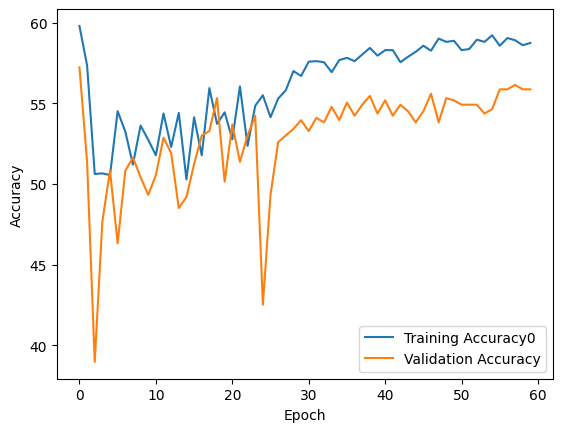

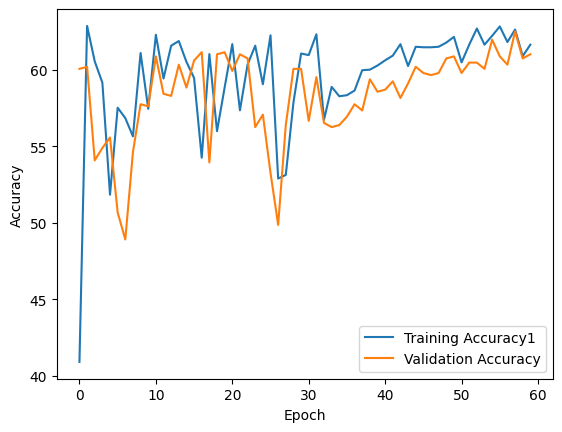

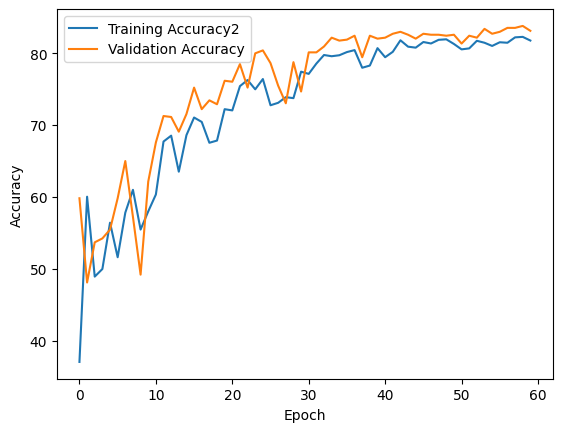

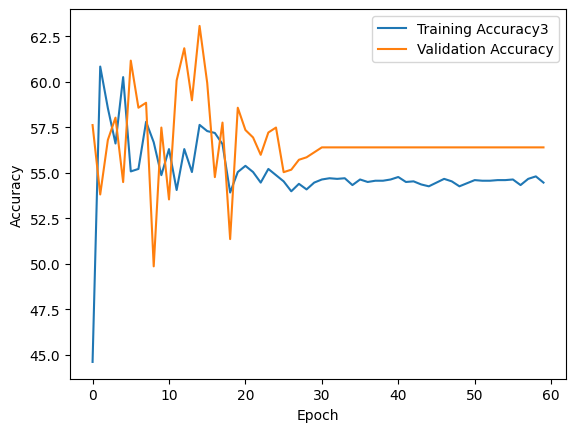

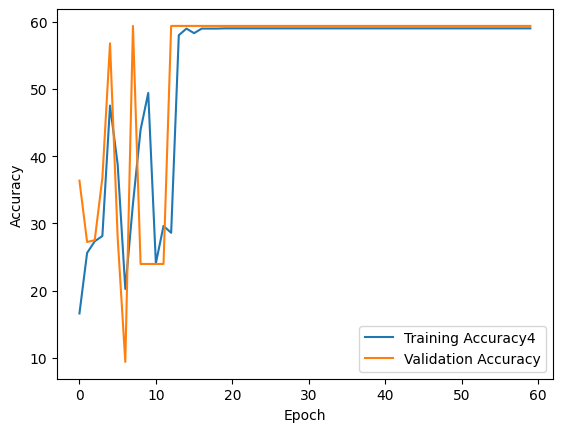

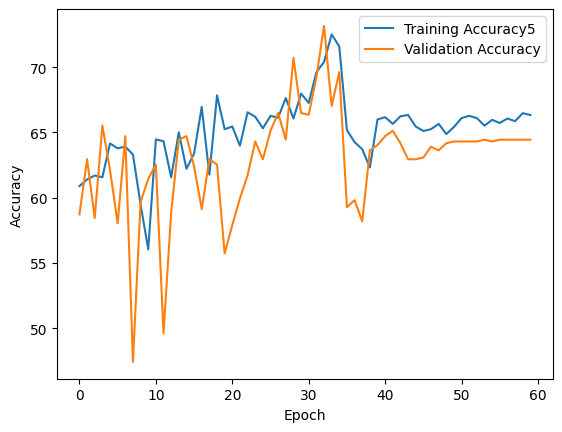

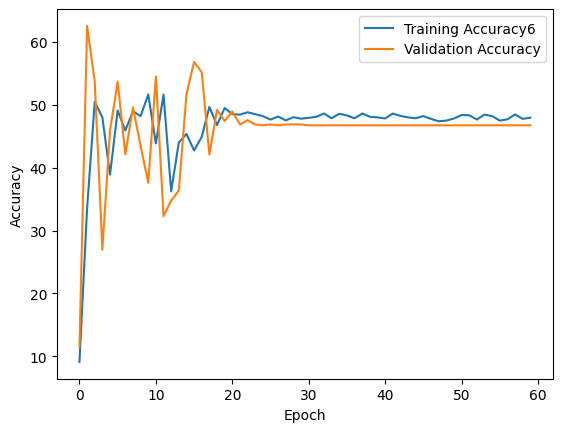

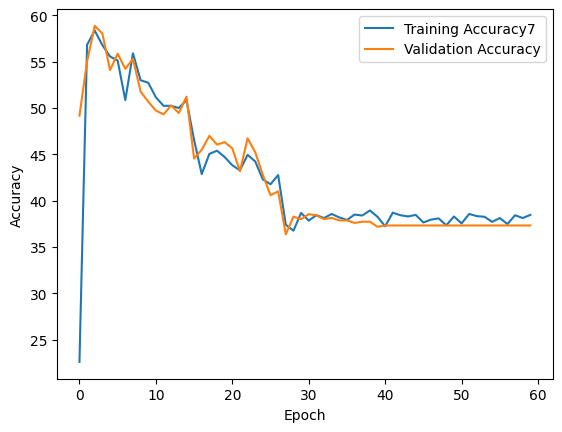

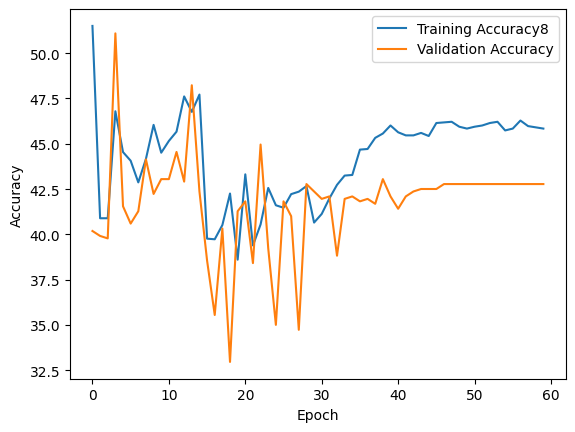

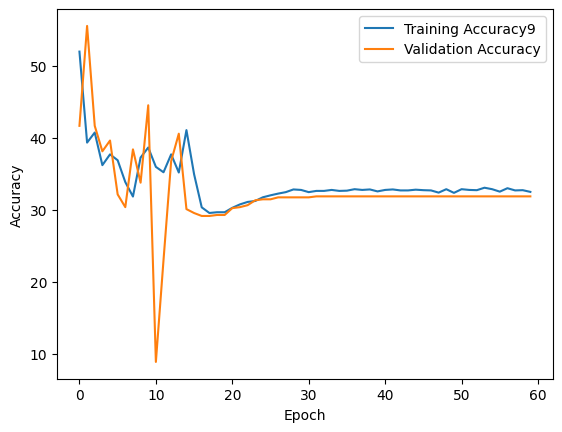

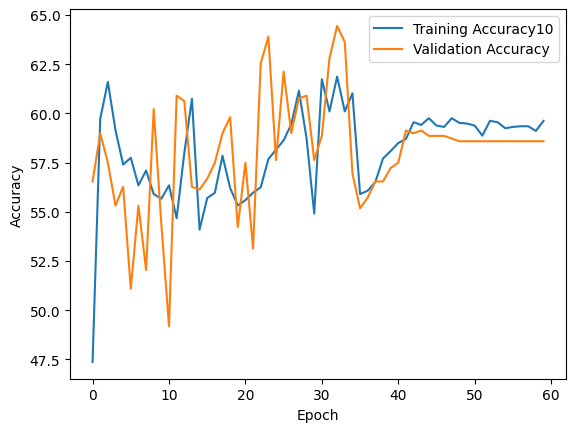

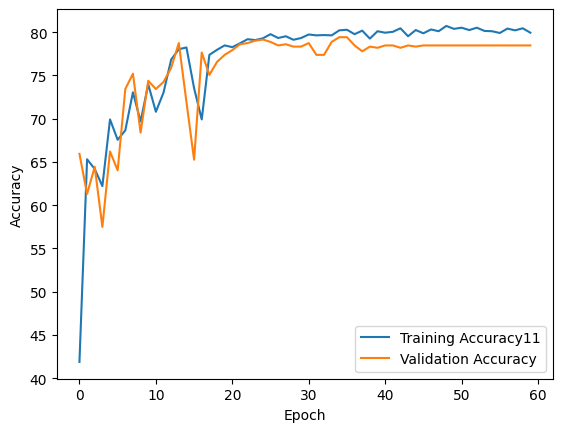

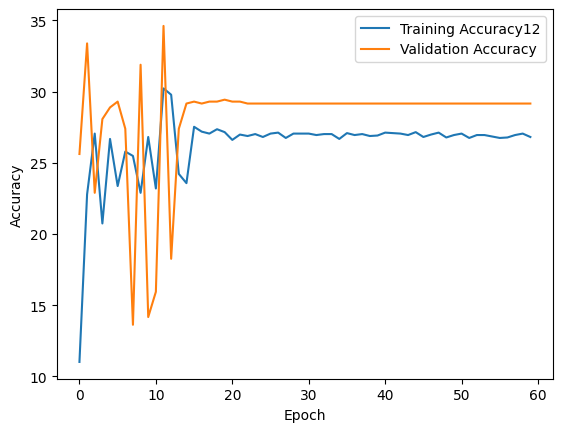

In [47]:
for i in range(13):
    plt.plot(train_accuracies[i], label=f'Training Accuracy{i}')
    plt.plot(val_accuracies[i], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

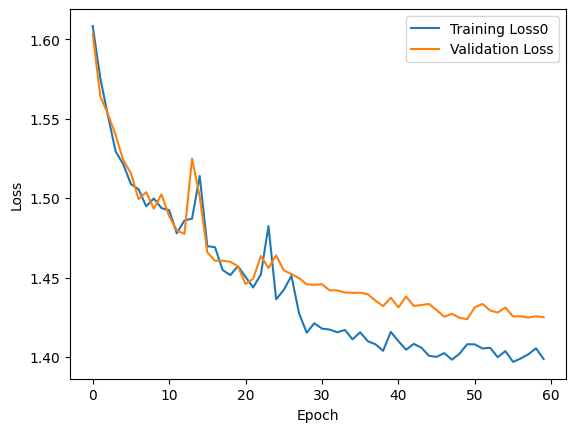

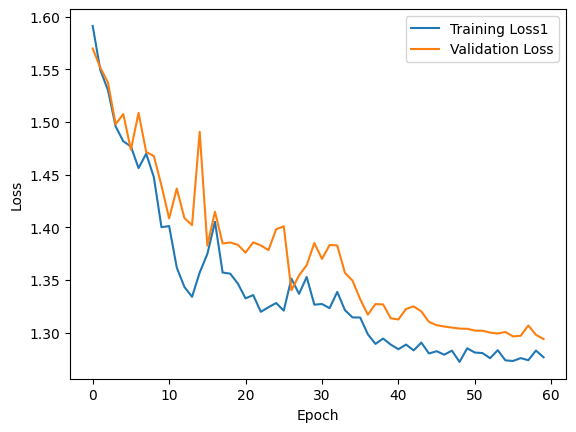

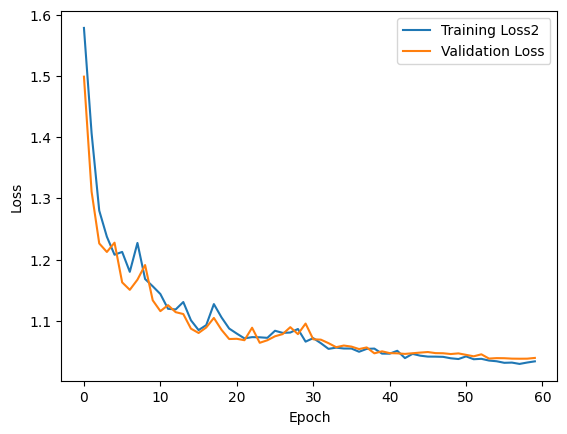

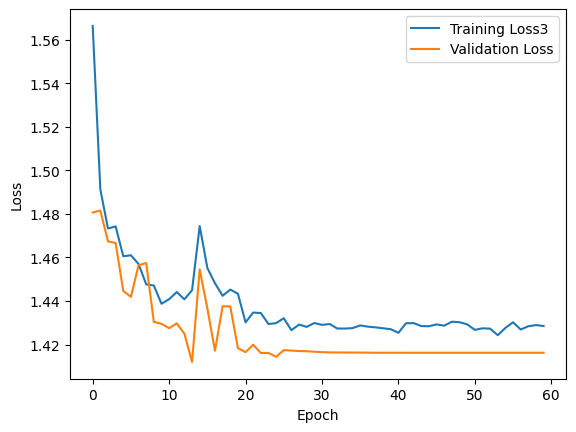

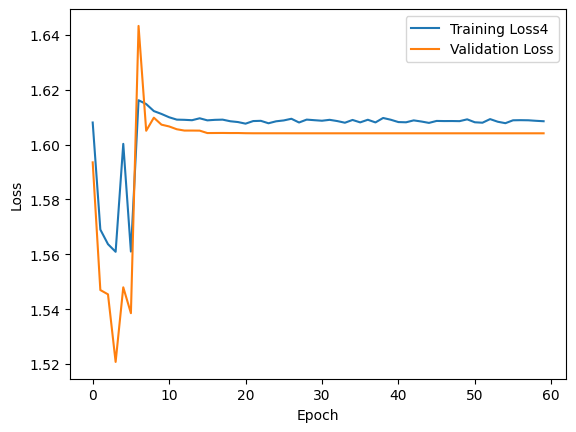

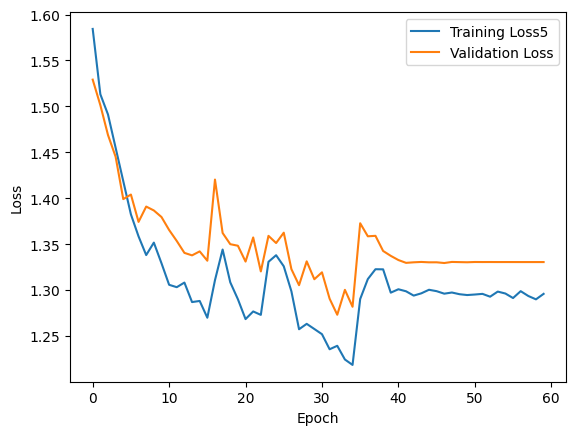

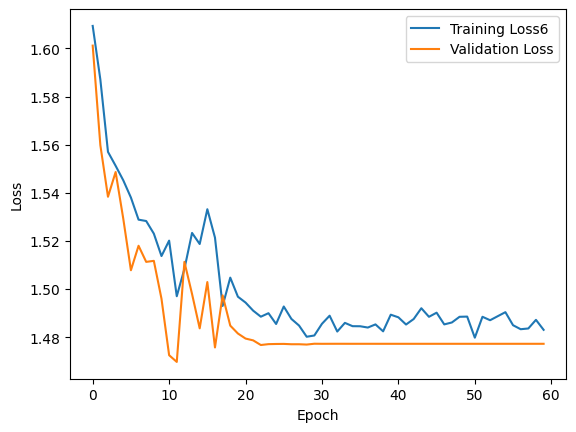

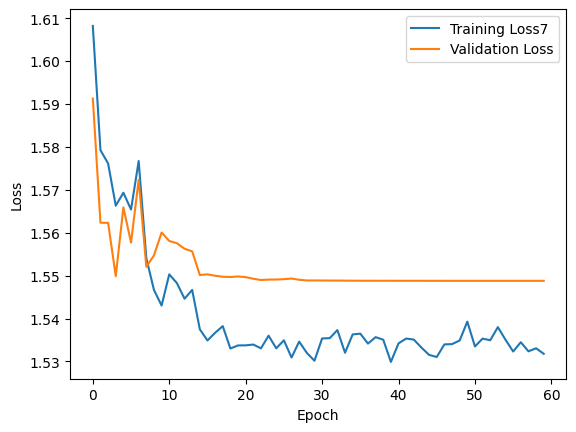

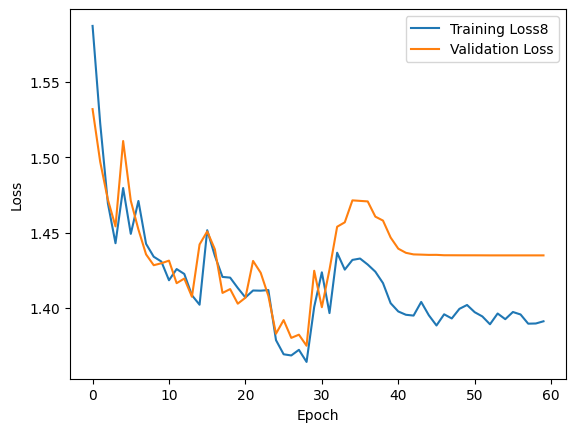

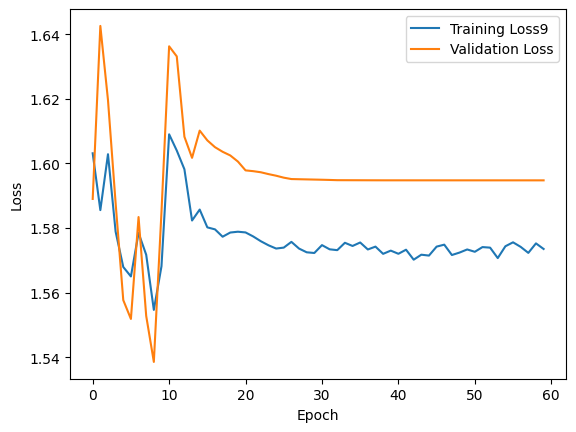

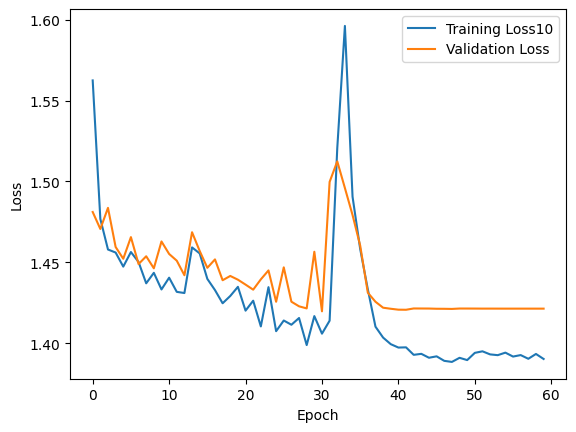

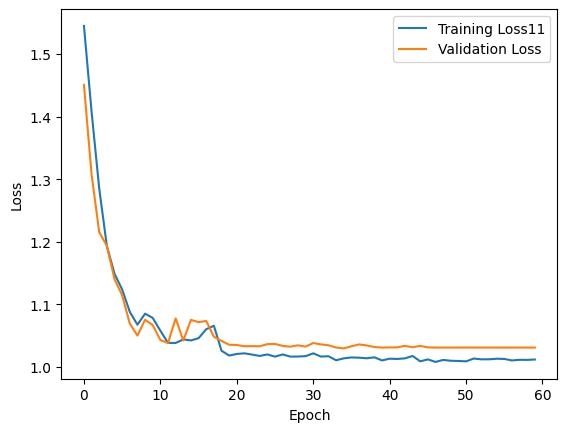

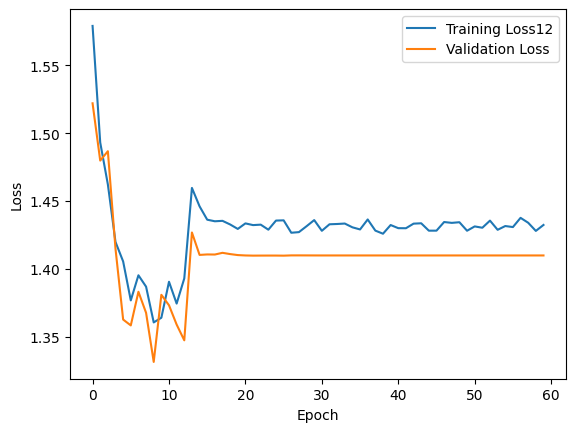

In [48]:
for i in range(13):
    plt.plot(train_losses[i], label=f'Training Loss{i}')
    plt.plot(val_losses[i], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for x_batch,  y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    conf_matrix = confusion_matrix(all_targets, all_predictions)
    class_report = classification_report(all_targets, all_predictions,zero_division=0)

    print(f'Validation Accuracy: {accuracy}\n')
    print(f'Confusion Matrix:\n{conf_matrix}\n')
    print(f'Classification Report:\n{class_report}\n')
    print("____________________________________________________________________________________")


In [50]:
evaluate_model(models[0], test_dataloader_0)
evaluate_model(models[1], test_dataloader_1)
evaluate_model(models[2], test_dataloader_2)
evaluate_model(models[3], test_dataloader_3)
evaluate_model(models[4], test_dataloader_4)
evaluate_model(models[5], test_dataloader_5)
evaluate_model(models[6], test_dataloader_6)
evaluate_model(models[7], test_dataloader_7)
evaluate_model(models[8], test_dataloader_8)
evaluate_model(models[9], test_dataloader_9)
evaluate_model(models[10], test_dataloader_10)
evaluate_model(models[11], test_dataloader_11)
evaluate_model(models[12], test_dataloader_12)

Validation Accuracy: 0.55858310626703

Confusion Matrix:
[[257  16  25 110  12]
 [ 18  19  18  13  12]
 [ 10   0  15   9   0]
 [ 35   5  24 112   6]
 [  3   1   3   4   7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.61      0.69       420
           1       0.46      0.24      0.31        80
           2       0.18      0.44      0.25        34
           3       0.45      0.62      0.52       182
           4       0.19      0.39      0.25        18

    accuracy                           0.56       734
   macro avg       0.42      0.46      0.41       734
weighted avg       0.63      0.56      0.58       734


____________________________________________________________________________________
Validation Accuracy: 0.6103542234332425

Confusion Matrix:
[[334  14  29  21  20]
 [ 22  35   2   1   0]
 [  0   2  35   1   0]
 [ 56  24  82  32   6]
 [  0   3   3   0  12]]

Classification Report:
              precision    re